In [1]:
def wcss(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_pix2world(x, y ,0)
    return [recx, recy]

In [2]:
def wcss3(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_world2pix(x, y ,0)
    return [recx, recy]

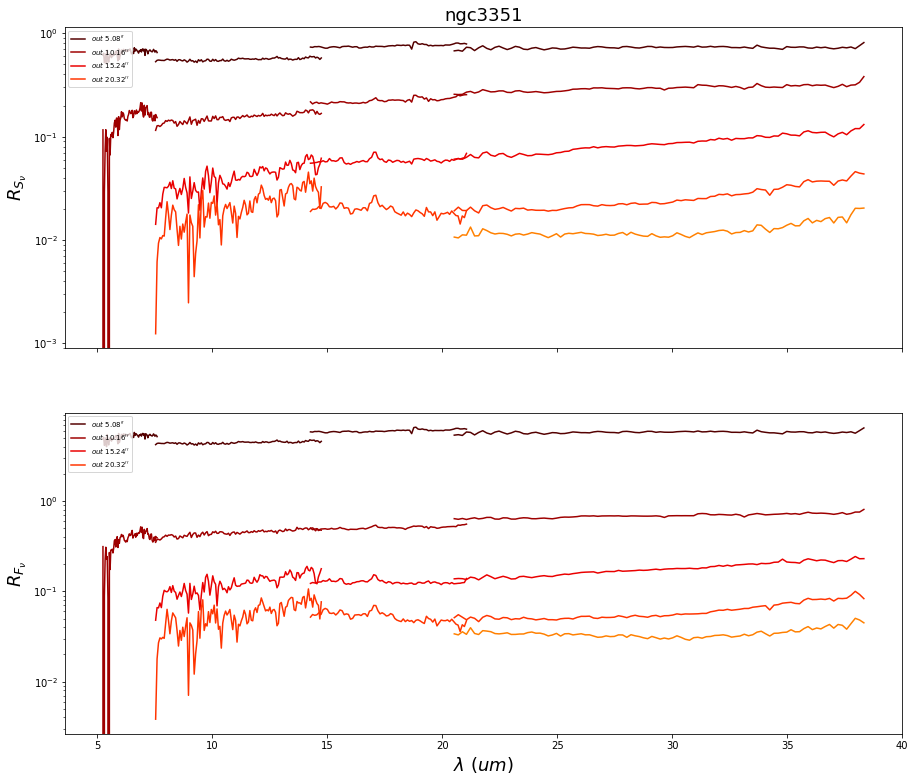

In [20]:
Plot_ratiooo(['ngc3351_SB'], 3, 10, 'LL2')

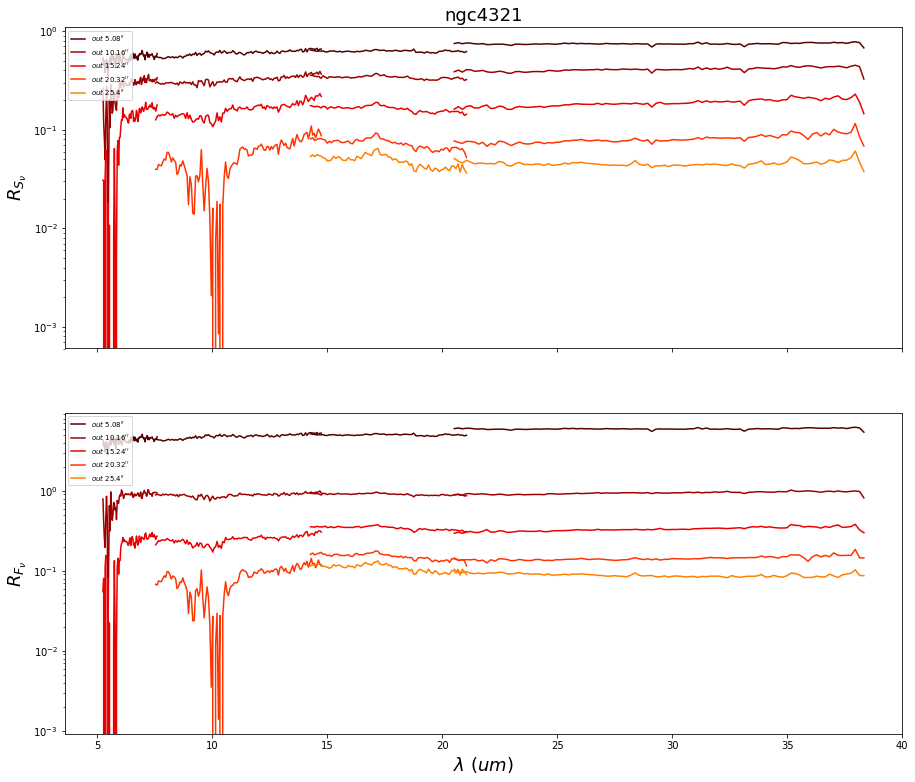

In [22]:
Plot_ratiooo(['ngc4321_L'], 3, 10, 'LL2')

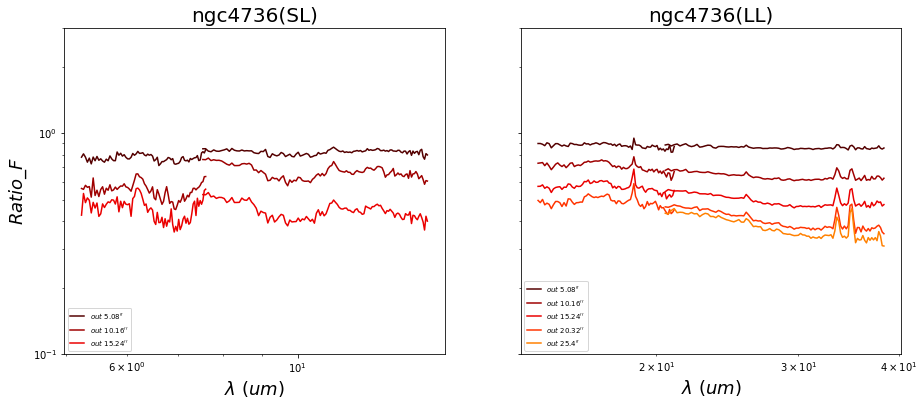

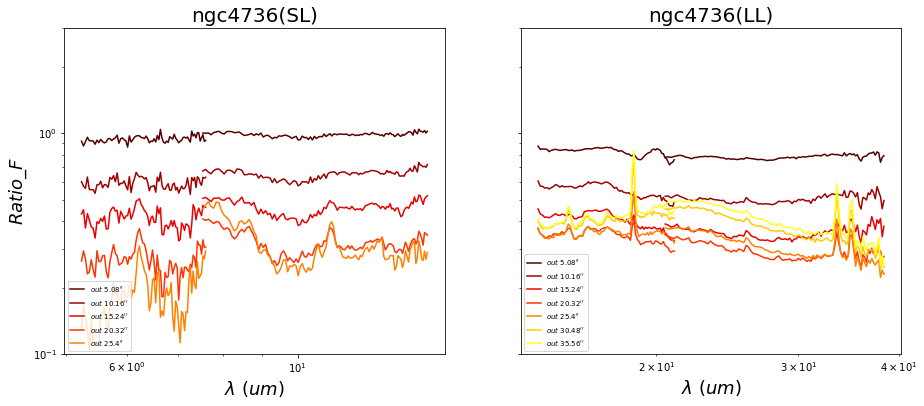

In [137]:
#Plot_ratio(['ngc4736_LINER'], 5, 10, 'LL2')

In [8]:
def Plot_spec(gal_name, sn, n_pix, O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits
    from astropy.table import Table


    data_mode = ['SL2','SL1','LL2','LL1']
#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
#gal_name = ['ngc{0}'.format(str(3031))]

    for name in gal_name:
        f, ax = plt.subplots(1, 1, figsize=[15,9], sharey = True)
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        for mode in data_mode:
            file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
            file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            flux_header = cube['PRIMARY'].header
#    print(n)
            flux_max = flux[xx[0]][yy[0]]
            flux_max_u = flux_u[xx[0]][yy[0]]

            Spec = Table([wave, flux_max, flux_max_u], names = ('Wavelength','Flux','Uncertainty'))
            Spec['Wavelength'].format = '.5f'
            Spec['Flux'].format = '.5f'
            Spec['Uncertainty'].format = '.6f'
            dirs = 'Spectra_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) != True):
                os.makedirs(dirs)
            Spec.write(dirs+'/{0}_{1}_CenPix.tbl'.format(name.split('_')[0], mode),format='ascii.ipac',overwrite=True)
            if(mode == O2):
                ax.errorbar(wave, flux_max, flux_max_u, ls='-', c='k', ecolor='k',elinewidth=1, label='$central\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_max, flux_max_u, ls='-', c='k', ecolor='k',elinewidth=1)

            bn = np.min([xx[0],yy[0],mm[0]-xx[0]-1,mm[1]-yy[0]-1])
            colors = plt.cm.hot(np.linspace(0,1,n_pix))
            for i in range(1,bn+1,1):
                flux_part = flux[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                flux_cen = flux[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = flux_u[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
#                    print((flux_part_u[mask_part]).shape)
                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = flux_u[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
#                    Ratio = flux_out/flux_max
                    Spec = Table([wave, flux_out, flux_out_u], names = ('Wavelength','Flux','Uncertainty'))
                    Spec['Wavelength'].format = '.5f'
                    Spec['Flux'].format = '.5f'
                    Spec['Uncertainty'].format = '.6f'
                    Spec.write(dirs+'/{0}_{1}_out{2}Pix.tbl'.format(name.split('_')[0], mode, str(i)),format='ascii.ipac',overwrite=True)
                    par = (i)*np.abs(flux_header['CDELT1'])*3600
#                        ax1.plot(wave, flux_out, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    if(mode == O2):
                        ax.errorbar(wave, flux_out, flux_out_u, ls='-', c=colors[i], ecolor=colors[i],elinewidth=1, label='$out\ $'+str(round(par,2))+'$\'\'$')
                        ax.legend(loc=2, fontsize='small')
                    else:
                        ax.errorbar(wave, flux_out, flux_out_u, ls='-', c=colors[i], ecolor=colors[i],elinewidth=1)

            ax.set_title(name.split('_')[0],fontsize=18)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim(10**0,10**3)
            ax.set_xlabel('$\lambda\ (um)$', fontsize=18)
            ax.set_ylabel('$Flux\ density\ (MJy\ sr^{-1})$', fontsize=18)
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) == False):
                os.makedirs(dirs)
            f.savefig(dirs+'/{0}_rSpec.png'.format(name.split('_')[0]))
    return

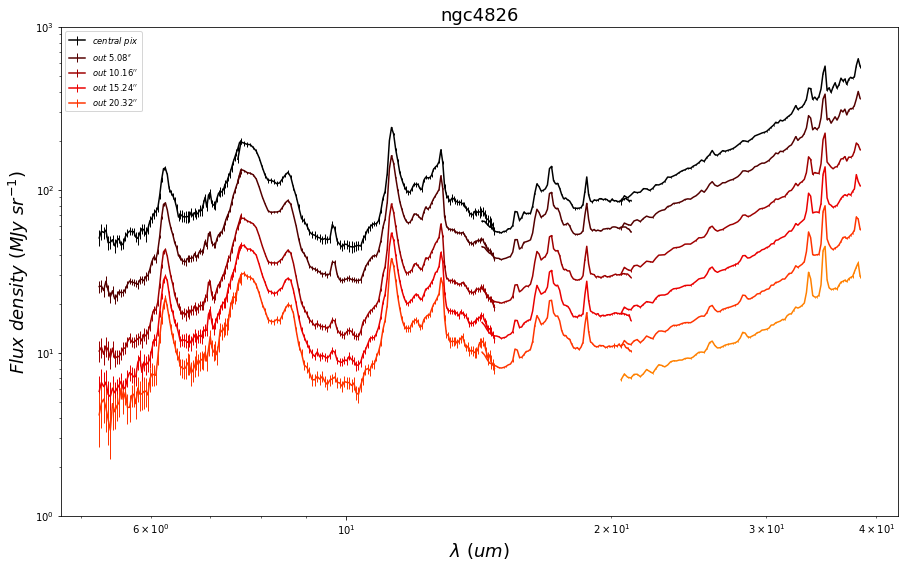

In [9]:
Plot_spec(['ngc4826_Sy2'], 3, 10, 'LL2')

In [35]:
# for spectra extraction of spaxel
def Pix_speccc(gal_name, sn, O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits
    from astropy.table import Table


    data_mode = ['SL2','SL1','LL2','LL1']
#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
#gal_name = ['ngc{0}'.format(str(3031))]

    for name in gal_name:
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        for ii in [-2, -1, 0, 1, 2]:
            for jj in [-2, -1, 0, 1, 2]:
                Wwave = np.array([])
                Sspec = np.array([])
                Sspec_u = np.array([])
                for mode in data_mode:
                    file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
                    file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
                    if(os.path.isfile(file_n)):
                        cube = fits.open(file_n)
                        cube_u = fits.open(file_u)
                    else:
                        print('No such file:{0}'.format(file_n))
                        continue

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
                    flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                    flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
                    flux_header = cube[0].header
                    crpix = wcss3(flux_header, crval[0], crval[1])
                    mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
                    xx = [int(round(crpix[0][0],0))]
                    yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)

                    wave = cube['WCS-TAB'].data[0][0]
                    wave.resize(len(wave))
                    flux_nnn = flux[xx[0]+ii][yy[0]+jj]
                    flux_nnn_u = flux_u[xx[0]+ii][yy[0]+jj]

                    flux_header = cube['PRIMARY'].header

                    if(mode == 'SL2'):
                        Sspec = np.concatenate((Sspec, flux_nnn))
                        Sspec_u = np.concatenate((Sspec_u, flux_nnn_u))
                        Wwave = np.concatenate((Wwave, wave))
                    if(mode == 'SL1'):
                        mask1 = wave > Wwave[-1]
                        mask2 = wave < wave[-3]
                        mask = mask1*mask2
                        Sspec = np.concatenate((Sspec, flux_nnn[mask]))
                        Sspec_u = np.concatenate((Sspec_u, flux_nnn_u[mask]))
                        Wwave = np.concatenate((Wwave, wave[mask]))
                    if(mode == 'LL2'):
                        mask1 = wave > Wwave[-1]
                        mask2 = wave < wave[-3]
                        mask = mask1*mask2
                        Sspec = np.concatenate((Sspec, flux_nnn[mask]))
                        Sspec_u = np.concatenate((Sspec_u, flux_nnn_u[mask]))
                        Wwave = np.concatenate((Wwave, wave[mask]))
                    if(mode == 'LL1'):
                        mask = wave > Wwave[-1]
                        Sspec = np.concatenate((Sspec, flux_nnn[mask]))
                        Sspec_u = np.concatenate((Sspec_u, flux_nnn_u[mask]))
                        Wwave = np.concatenate((Wwave, wave[mask]))
                sr = (np.abs(flux_header['CDELT1'])*3600)**2
#                    print(sr)
                Sspec = Sspec*sr
                Sspec_u = Sspec_u*sr
                band = np.zeros(len(Wwave), dtype=int)
                Spec = Table([Wwave, Sspec, Sspec_u, band], names = ('wavelength','flux','sigma','band'))
                Spec['wavelength'].format = '.8f'
                Spec['flux'].format = '.8f'
                Spec['sigma'].format = '.9f'
#                    Spec['band'].format = '6d'
                dirs = 'Spectra/{1}'.format(O2,name.split('_')[0])
                if(os.path.exists(dirs) != True):
                    os.makedirs(dirs)
                Spec.write(dirs+'/{0}_{1}_Pix.tbl'.format(str(ii+3), str(jj+3)),format='ascii.ipac',overwrite=True)
    return

In [36]:
Pix_speccc(['ngc4826_Sy2'], 3, 'LL2')

In [8]:
def Pix_speccc(gal_name, sn, O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits


    data_mode = ['SL2','SL1','LL2','LL1']
#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
#gal_name = ['ngc{0}'.format(str(3031))]

    for name in gal_name:
        f, ax = plt.subplots(1, 1, figsize=[15,9], sharey = True)
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        for mode in data_mode:
            file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
            file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            flux_header = cube['PRIMARY'].header
#    print(n)
            flux_max = flux[xx[0]][yy[0]]
            flux_max_u = flux_u[xx[0]][yy[0]]
            if(mode == O2):
                ax.errorbar(wave, flux_max, flux_max_u, ls='-', c='k', ecolor='k',elinewidth=1, label='$central\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_max, flux_max_u, ls='-', c='k', ecolor='k',elinewidth=1)

            flux_left = flux[xx[0]-1][yy[0]]
            flux_left_u = flux_u[xx[0]-1][yy[0]]
            if(mode == O2):
                ax.errorbar(wave, flux_left, flux_left_u, ls='-', c='c', ecolor='c',elinewidth=1, label='$left\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_left, flux_left_u, ls='-', c='c', ecolor='c',elinewidth=1)

            flux_right = flux[xx[0]+1][yy[0]]
            flux_right_u = flux_u[xx[0]+1][yy[0]]
            if(mode == O2):
                ax.errorbar(wave, flux_right, flux_right_u, ls='-', c='b', ecolor='b',elinewidth=1, label='$right\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_right, flux_right_u, ls='-', c='b', ecolor='b',elinewidth=1)

            flux_above = flux[xx[0]][yy[0]+1]
            flux_above_u = flux_u[xx[0]][yy[0]+1]
            if(mode == O2):
                ax.errorbar(wave, flux_above, flux_above_u, ls='-', c='r', ecolor='r',elinewidth=1, label='$above\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_above, flux_above_u, ls='-', c='r', ecolor='r',elinewidth=1)

            flux_below = flux[xx[0]][yy[0]-1]
            flux_below_u = flux_u[xx[0]][yy[0]-1]
            if(mode == O2):
                ax.errorbar(wave, flux_below, flux_below_u, ls='-', c='m', ecolor='m',elinewidth=1, label='$below\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_below, flux_below_u, ls='-', c='m', ecolor='m',elinewidth=1)

            ax.set_title(name.split('_')[0],fontsize=18)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim(10**0,10**3)
            ax.set_xlabel('$\lambda\ (um)$', fontsize=12)
            ax.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=12)
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            f.savefig(dirs+'/{0}_rSpec.png'.format(name.split('_')[0]))

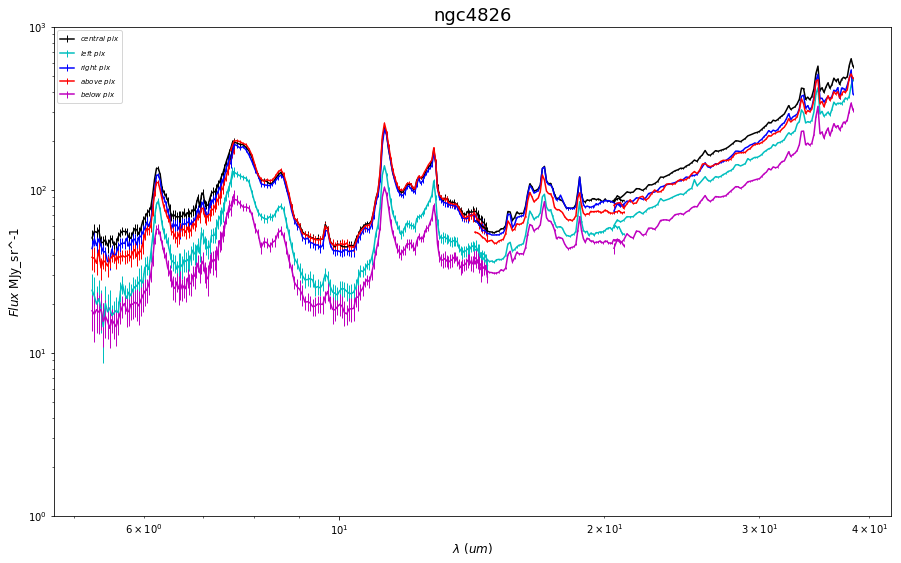

In [37]:
#Plot_speccc(['ngc4826_Sy2'], 5, 'LL2')